# ABOUT:

In [1]:
from recommenders.models.sar import SAR
from recommenders.datasets.python_splitters import python_stratified_split
from recommenders.utils.constants import SEED as DEFAULT_SEED
from recommenders.evaluation.python_evaluation import precision_at_k
from recommenders.models.deeprec.DataModel.ImplicitCF import ImplicitCF
from recommenders.models.deeprec.deeprec_utils import prepare_hparams
from recommenders.models.deeprec.models.graphrec.lightgcn import LightGCN
from recommenders.utils.timer import Timer

import pandas as pd
import os
import gzip
import json
import pandas as pd
import seaborn as sb
from scipy.sparse import save_npz, load_npz
from numpy import save, load 
import json
import numpy as np
import random
import pickle

import sys
sys.path.append(r'C:\Users\tanch\Desktop\Bot.World\Bot.World\src\main\api\fastapi')
sys.path.append(r'C:\Users\tanch\Desktop\Bot.World\Bot.World\src\main\api')
from model import load_sar_model
from bot_world_config import *

### bot_world_config

In [2]:
CONFIG = {}
CONFIG.update(load_database_config())
CONFIG.update(load_model_config())
CONFIG.update(load_session_config())
CONFIG.update(load_seller_config())
CONFIG.update(load_sar_config())
CONFIG.update(load_telegram_bot_config())

In [3]:
CONFIG

{'DATABASE_USER': 'ching',
 'DATABASE_PASSWORD': '978775!Rtj01',
 'DATABASE_HOST': 'aws-bot-world-mysql.c6ecc5e9b7no.ap-southeast-1.rds.amazonaws.com',
 'DATABASE_NAME': 'Arietes_Care',
 'PRODUCT_INFO_TABLE_NAME': 'product_info',
 'USE_RDS': False,
 'DATABASE_PATH_TANCH': 'C:\\Users\\tanch\\Desktop\\Bot.World\\Bot.World\\src\\main\\database\\arietes\\arietes.db',
 'DATABASE_PATH_DOCKER': '/database/arietes/arietes.db',
 'MODEL_TYPE': 'sar',
 'TOP_K': 10,
 'MODEL_SUPPORTED_TYPES': ['sar'],
 'SESSION_RECOMMENDATION_SIZE': 5,
 'SELLER_ID': '120171733',
 'SHOP_NAME': 'Arietes Care',
 'SHOP_URL': 'https://shopee.sg/arietes.acc',
 'COL_USER': 'user_id',
 'COL_ITEM': 'item_id',
 'COL_RATING': 'rating',
 'SIMILARITY_TYPE': 'jaccard',
 'MODEL_DIR': '/api/models/arietes-sar',
 'BOT_TOKEN': '6152761301:AAE-VFcRJn7r40lbNOEC5QX5rZCY4DjGULA'}

### config

In [4]:
KEYWORD_SHOPEE_RAW_TRANSACTION_FILE = "Order.all"
NON_KEYWORD_SHOPEE_RAW_TRANSACTION_FILE = "$"
DESIRED_COLS_TRANSACTION_FILE = ["Order ID", "Original Price", "Username (Buyer)", "Product Name", "product_id"]
TRANSACTION_ID_COL = ["Order ID"]
# USER_ID_COL = "user_id"
# ITEM_ID_COL = "item_id"
# RATING_COL = "rating"
TRANSACTION_TO_INTERACTION_MAPPING = {
    CONFIG['COL_USER']:"Username (Buyer)",
    CONFIG['COL_ITEM']:"product_id",
}

PATH_TO_RAW_MEDIA_FILE = r"C:\Users\tanch\Documents\NTU\NTU Year 4\FYP - GNN\data\shopee-20221117T041452Z-001\shopee\mass_update_media_info_120171733_20230224232836.xlsx"
PATH_TO_RAW_TRANSACTIONS_FOLDER = r"C:\Users\tanch\Documents\NTU\NTU Year 4\FYP - GNN\data\shopee-20221117T041452Z-001\shopee"

### model training config

In [5]:
MIN_UNIQUE_PURCHASES = 2
SPLIT_RATIO = 0.5
SEED = 0 
TOP_K = 10
BATCH_SIZE = 1024
MODEL_DIR = r"C:\Users\tanch\Desktop\Bot.World\Bot.World\src\main\api\models\arietes-sar"
MODEL_TRAINING_DATA_DIR = r"C:\Users\tanch\Desktop\Bot.World\Bot.World\src\dev\data\recommendation model training\arietes"

### Utils

In [6]:
"""
files containing the transactions are identified by keywords
IMPORTANT NOTE: transaction files SHOULD NOT be duplicated
"""
def get_transaction_filenames(folder_path:str, keyword:str, non_keyword:str):
    return [filename for filename in os.listdir(folder_path) if keyword in filename and non_keyword not in filename]
"""
Combine all transaction data into dataframe, with no processing 
"""
def get_transaction_data(folder_path:str, filenames:list):
    output = pd.DataFrame()
    for filename in filenames:
        data_path = os.path.join(folder_path,filename)
        data = pd.read_excel(data_path)
        output = pd.concat([output, data] , axis = 0)
    return output.reset_index(drop = True)
"""
Clean transaction data - very minimal cleaning
"""
def clean_transaction_data(dataframe, desired_columns):
    output = dataframe.copy()
    output = output[desired_columns]
    # # INTERACTIONS ARE UNIQUE BY COMPOSITE/MULTIPLE COLUMNS
    # output = output.drop_duplicates(subset = id_cols)
    return output
"""
Create a id mapping for a column
"""
def generate_ids(pandas_series):
    mapping = dict(enumerate(pandas_series.unique().tolist()))
    reverse_mapping = {v:k for k,v in mapping.items()}
    return reverse_mapping
"""
Transform into interaction data that is the input to personalized recommendation models
notes:
take only unique user_item interactions
"""
def transform_transaction_to_interaction_data(transaction_dataframe, user_id_col, item_id_col, transaction_interaction_mapping, rating_col, generate_ids = False):
    output = pd.DataFrame()
    user_id_mapping, item_id_mapping = None, None
    if generate_ids:
        user_id_mapping = generate_ids(transaction_dataframe[transaction_interaction_mapping[user_id_col]])
        item_id_mapping = generate_ids(transaction_dataframe[transaction_interaction_mapping[item_id_col]])
        output[user_id_col] = transaction_dataframe[transaction_interaction_mapping[user_id_col]].map(user_id_mapping)
        output[item_id_col] = transaction_dataframe[transaction_interaction_mapping[item_id_col]].map(item_id_mapping)
    else: 
        output[user_id_col] = transaction_dataframe[transaction_interaction_mapping[user_id_col]]
        output[item_id_col] = transaction_dataframe[transaction_interaction_mapping[item_id_col]]
    # user-item interactions are unique
    output = pd.DataFrame(output.groupby(by = [user_id_col, item_id_col]).size(), columns = [rating_col])
    output = output.reset_index()
    return output, user_id_mapping, item_id_mapping
"""
Make interaction data more suitable for recommedation model 
notes:
all interactions have the same weight i.e. rating 1
"""
def clean_interaction_data(config, dataframe, equalize_interaction_weights = True):
    output = dataframe.copy()
    # all interaction weights are 1
    if equalize_interaction_weights:
        dataframe[config['COL_RATING']] = 1
    # want model inputs to be string
    output[config['COL_ITEM']] = output[config['COL_ITEM']].astype(str)
    return output
"""
Generate training and testing sets
notes:
Training set contains all user-item interactions that NOT IN test set
Test set contains only user-item interactions from users that had at least 2 interactions from the dataset
    i.e. users with only 1 interaction from the dataset will not be tested (because we need at least 2 to train and test)
"""
def train_test_split(config, dataframe):
    # take users with at least "min_purchases" number of purchases
    warm_interactions = keep_warm(dataframe, config['COL_USER'], MIN_UNIQUE_PURCHASES)
    # generate test set containing users with at least "min_purchases" number of purchases
    _, test = python_stratified_split(warm_interactions, ratio=SPLIT_RATIO,
                                      min_rating=1, filter_by='user', 
                                      col_user=config['COL_USER'], col_item=config['COL_ITEM'], 
                                      seed=SEED)
    # generate train set, which are interactions not found in test set
    train = dataframe.merge(test, on=[config['COL_USER'], config['COL_ITEM']], how='left', indicator=True)
    train = train[train['_merge'] == 'left_only'][[config['COL_USER'], config['COL_ITEM']]]
    # risky 
    train[config['COL_RATING']] = 1
    return train, test

"""
Warm users refer to users that have bought at least x number of items from the shop
"""
def keep_warm(dataframe, target_col, minimum_count):
    output = dataframe.groupby(by = [target_col]).filter(lambda x : len(x)>=minimum_count)
    return output.reset_index(drop = True)


def show_dataset_stats(config, dataframe):
    print(f"""
        Total Interactions: {len(dataframe)}
        Unique Users: {dataframe[config['COL_USER']].nunique()}
        Unique Items: {dataframe[config['COL_ITEM']].nunique()}
        """)
    


### Get raw data
- consists of transactional files (user item interactions) ad media files (image urls)

In [7]:
def get_product_data():
    data = pd.read_excel(PATH_TO_RAW_MEDIA_FILE
                  ,sheet_name= "Sheet2", header = None, names = ["product_id", "product_name", "categories", "image_url"])
    return data
media_data = get_product_data()

In [8]:
media_data.head()

,product_id,product_name,categories,image_url
0,23826146098,Ultrasonic Aroma Humidifier Led light changing,101129 - Home & Living/Home Fragrance & Aromat...,https://cf.shopee.sg/file/sg-11134207-23020-9n...
1,23821255327,Heavy Duty Canvas Tote Bags Stitching Contrast...,100093 - Women Bags/Tote Bags,https://cf.shopee.sg/file/sg-11134207-23020-yu...
2,23821254972,Hot Products EMS Vibration RF V Shape Other Ho...,101661 - Beauty/Beauty Tools/Facial Care Tools...,https://cf.shopee.sg/file/sg-11134207-23020-k1...
3,23821143235,Wart Removal Cream Natural Herbal Skin Care Re...,100427 - Health/Medical Supplies/First Aid Sup...,https://cf.shopee.sg/file/sg-11134207-23020-1u...
4,23720393304,Cute Kids Bag Cartoon Schoolbag Shoulder Bag S...,101744 - Baby & Kids Fashion/Baby & Kids Acces...,https://cf.shopee.sg/file/sg-11134207-23010-t7...


In [9]:
# media_data.to_csv(os.path.join(PATH_TO_RAW_TRANSACTIONS_FOLDER, "cleaned_transactions.csv"), index = False)

In [10]:
transaction_filenames = get_transaction_filenames(PATH_TO_RAW_TRANSACTIONS_FOLDER, KEYWORD_SHOPEE_RAW_TRANSACTION_FILE, NON_KEYWORD_SHOPEE_RAW_TRANSACTION_FILE)
transaction_data = get_transaction_data(PATH_TO_RAW_TRANSACTIONS_FOLDER, transaction_filenames)

In [11]:
transaction_data = transaction_data.merge(media_data, left_on = "Product Name", right_on = "product_name", how = "inner")

In [20]:
def long_tail_problem():
    print("Num users with more than 1 purchase: ",sum(transaction_data["Username (Buyer)"].value_counts()>1))
    print("Num users with only 1 purchase: ", sum(transaction_data["Username (Buyer)"].value_counts()==1))

In [21]:
long_tail_problem()

Num users with more than 1 purchase:  1676
Num users with only 1 purchase:  6132


In [22]:
transaction_data.head()

,Order ID,Order Status,Cancel reason,Return / Refund Status,Tracking Number*,Shipping Option,Shipment Method,Estimated Ship Out Date,Ship Time,Order Creation Date,...,Province,Country,Zip Code,Remark from buyer,Order Complete Time,Note,product_id,product_name,categories,image_url
0,210701QSRHFY5W,Completed,NaN,NaN,SJNT957750266,J&T Express,pickup,2021-07-05 13:52,2021-07-02 16:45,2021-07-01 13:52,...,NaN,SG,734688,NaN,2021-07-03 20:34,NaN,8406662315,Hot Magnetic Back Support Brace Belt Lumbar Lo...,100432 - Health/Medical Supplies/Injury & Disa...,https://cf.shopee.sg/file/333f8f876721b0dd1a11...
1,210708D2XTB5TJ,Completed,NaN,NaN,SJNT390072266,J&T Express,pickup,2021-07-12 21:24,2021-07-09 18:42,2021-07-08 21:24,...,NaN,SG,459109,NaN,2021-07-16 08:08,NaN,8406662315,Hot Magnetic Back Support Brace Belt Lumbar Lo...,100432 - Health/Medical Supplies/Injury & Disa...,https://cf.shopee.sg/file/333f8f876721b0dd1a11...
2,210725SHRE6FM4,Completed,NaN,NaN,SJNT345680452,J&T Express,pickup,2021-07-27 10:08,2021-07-26 14:33,2021-07-25 10:07,...,NaN,SG,545084,NaN,2021-07-30 21:44,NaN,8406662315,Hot Magnetic Back Support Brace Belt Lumbar Lo...,100432 - Health/Medical Supplies/Injury & Disa...,https://cf.shopee.sg/file/333f8f876721b0dd1a11...
3,211002RFG2874R,Completed,NaN,NaN,SJNT585561873,J&T Express,pickup,2021-10-05 10:35,2021-10-02 13:39,2021-10-02 10:34,...,NaN,SG,208787,NaN,2021-10-04 12:37,NaN,8406662315,Hot Magnetic Back Support Brace Belt Lumbar Lo...,100432 - Health/Medical Supplies/Injury & Disa...,https://cf.shopee.sg/file/333f8f876721b0dd1a11...
4,21100545WNFN2V,Cancelled,Cancelled by buyer. Reason: Others,NaN,NaN,J&T Express,pickup,NaN,NaN,2021-10-05 22:36,...,NaN,SG,460106,NaN,NaN,NaN,8406662315,Hot Magnetic Back Support Brace Belt Lumbar Lo...,100432 - Health/Medical Supplies/Injury & Disa...,https://cf.shopee.sg/file/333f8f876721b0dd1a11...


### Data PreProcessing
- Convert Raw Transactional Data into Interaction Data that can be input into recommender models
- Highlight steps:
    - Interaction Data Should be Warm - i.e. users should have at least x purchases, where x must be above 1
    - Item and User Names are mapped to IDs
    - If a customer buys an item multiple times, that information gets added to the "rating" column, denoting the strength of the r/s

In [25]:
processed_transaction_data = clean_transaction_data(transaction_data, DESIRED_COLS_TRANSACTION_FILE)

In [26]:
processed_transaction_data.head()

,Order ID,Original Price,Username (Buyer),Product Name,product_id
0,210701QSRHFY5W,15.8,iralia7801,Hot Magnetic Back Support Brace Belt Lumbar Lo...,8406662315
1,210708D2XTB5TJ,15.8,z8852ay3gp,Hot Magnetic Back Support Brace Belt Lumbar Lo...,8406662315
2,210725SHRE6FM4,9.9,6ltmsjbpw2,Hot Magnetic Back Support Brace Belt Lumbar Lo...,8406662315
3,211002RFG2874R,9.9,obuia9a4kv,Hot Magnetic Back Support Brace Belt Lumbar Lo...,8406662315
4,21100545WNFN2V,9.9,ahliahyunos,Hot Magnetic Back Support Brace Belt Lumbar Lo...,8406662315


In [28]:
interaction_data, user_id_mapping, item_id_mapping = transform_transaction_to_interaction_data(processed_transaction_data, CONFIG['COL_USER'], CONFIG['COL_ITEM'], TRANSACTION_TO_INTERACTION_MAPPING, CONFIG['COL_RATING'])

In [15]:
interaction_data.head()

,user_id,item_id,rating
0,.naminani_,12009015584,1
1,.sekura.,13671455179,1
2,.xinyi.89,15886095522,1
3,00dwnptymc,10690827974,4
4,02utgw4m43,21837443125,1
...,...,...,...
8786,zyza208,20901098335,2
8787,zziplex,20901098335,1
8788,zzzaharazzz,13671455179,1
8789,zzzmon5ter,5834933106,2


In [36]:
# this should be used to train the DEPLOYMENT model 
cleaned_interaction_dataset  = clean_interaction_data(CONFIG, interaction_data)

In [37]:
cleaned_interaction_dataset.dtypes

user_id    object
item_id    object
rating      int64
dtype: object

In [40]:
cleaned_interaction_dataset.head()

,user_id,item_id,rating
0,.naminani_,12009015584,1
1,.sekura.,13671455179,1
2,.xinyi.89,15886095522,1
3,00dwnptymc,10690827974,1
4,02utgw4m43,21837443125,1


In [19]:
show_dataset_stats(CONFIG, cleaned_interaction_dataset)


        Total Interactions: 8791
        Unique Users: 7808
        Unique Items: 252
        


In [21]:
cleaned_interaction_dataset[CONFIG['COL_USER']].value_counts()

weirdyellow      12
54bakery          8
bignphat          7
alexsanzo         7
buycwy            6
                 ..
jolenetong95      2
josephchua123     2
joytan74          2
jslucky           2
mcklair           2
Name: user_id, Length: 769, dtype: int64

### Train and Test Processing
- Test set fulfills the conditions:
    1. unseen in training set
    2. users here must have had at least 2 interactions
- training set fulfilled the conditions:
    1. contains interactions not found in test set
    2. allowed to have users with 1 (or more) interactions

In [86]:
train, test = train_test_split(CONFIG, cleaned_interaction_dataset)

In [91]:
show_dataset_stats(CONFIG, train)


        Total Interactions: 7960
        Unique Users: 7808
        Unique Items: 249
        


In [92]:
show_dataset_stats(CONFIG, test)


        Total Interactions: 831
        Unique Users: 769
        Unique Items: 112
        


In [89]:
# test.to_pickle(os.path.join(MODEL_TRAINING_DATA_DIR, "test.pkl"))
# train.to_pickle(os.path.join(MODEL_TRAINING_DATA_DIR, "train.pkl"))

In [7]:
train = pd.read_pickle(os.path.join(MODEL_TRAINING_DATA_DIR, "train.pkl"))
test = pd.read_pickle(os.path.join(MODEL_TRAINING_DATA_DIR, "test.pkl"))

## Model Training and Evaluation: SAR

In [103]:
performance = {}

In [102]:
# Similarity types: ["cooccurrence" | "cosine" | "inclusion index" | "jaccard" | "lift" | "mutual information" | "lexicographers mutual information"]
model_sar = SAR(
    col_user=CONFIG['COL_USER'],
    col_item=CONFIG['COL_ITEM'],
    col_rating=CONFIG['COL_RATING'],
    # col_timestamp=COL_TIMESTAMP,
    similarity_type= "lift", 
    time_decay_coefficient=30, 
    timedecay_formula=False,
    normalize=False
)

In [97]:
# with Timer() as train_time:
model_sar.fit(train)

In [104]:
sar_load(model_sar, MODEL_DIR)

## User based recommendation
- recommend based on user ID input

In [106]:
user_top_k = model_sar.recommend_k_items(test, top_k=TOP_K, remove_seen=True)
eval_precision = precision_at_k(test, user_top_k, col_user=CONFIG['COL_USER'], col_item=CONFIG['COL_ITEM'], col_rating=CONFIG['COL_RATING'], k=CONFIG['TOP_K'])
performance['SAR_user_based_recommend'] = eval_precision
performance

{'SAR_user_based_recommend': 0.03446033810143043}

In [107]:
user_top_k

,user_id,item_id,prediction
0,1cp2upf59l,20106913826,0.000916
1,1cp2upf59l,14591891500,0.000250
2,1cp2upf59l,4636251387,0.000211
3,1cp2upf59l,18516275838,0.000172
4,1cp2upf59l,11845518959,0.000095
...,...,...,...
7685,zvimyrl,21602981763,0.000000
7686,zvimyrl,19814763342,0.000000
7687,zvimyrl,13950585519,0.000000
7688,zvimyrl,18414274019,0.000000


## Popularity based recommendation
- recommend most interacted items

In [108]:
"""
Recommend based on popularity:
notes:
For every user in the test set
    Recommend the top k most popular items 
    (So all users get the same recommendations)
Evaluate on test set
"""
def construct_popular_predictions_table(test, model, top_k):
    user_ids = test.user_id.unique()
    popular_items = model.get_popularity_based_topk(top_k = top_k)
    output = pd.DataFrame()
    for user_id in user_ids:
        popular_items["user_id"] = user_id
        output = pd.concat([output, popular_items], axis = 0)
    return output

In [109]:
pop_top_k = construct_popular_predictions_table(test = test, model = model_sar, top_k = TOP_K)
eval_precision = precision_at_k(test, pop_top_k, col_user=CONFIG['COL_USER'], col_item=CONFIG['COL_ITEM'], col_rating=CONFIG['COL_RATING'], k=CONFIG['TOP_K'])
performance['SAR_popularity_based_recommend'] = eval_precision
performance     

{'SAR_user_based_recommend': 0.03446033810143043,
 'SAR_popularity_based_recommend': 0.042392717815344594}

## Item based recommendation
- recommend based on an item ID input

In [110]:
"""
Recommend based on an item input
notes:
For every user-item pair in test set,
    For that user, 
        take an interacted item in training set
        make a prediction with that item
Evaluate on test set
"""
def construct_item_based_predictions_table(config, train, test, model):
    output = pd.DataFrame()
    # for every user-item interaction in test set
    for i in range(len(test)):
        test_row = test.iloc[i]
        test_user_id = test_row[config['COL_USER']]
        test_item_id = test_row[config['COL_ITEM']]
        # get the user's historical items
        historical_interactions = train[train[config['COL_USER']]==test_user_id][config['COL_ITEM']].tolist()
        # recommend based on 1 of that item
        recommended_item_ids = model.get_item_based_topk(items = pd.DataFrame({"item_id":random.sample(historical_interactions, 1)}), 
                                                         top_k=config['TOP_K'])
        recommended_item_ids[config['COL_USER']] = test_user_id
        output = pd.concat([output, recommended_item_ids], axis = 0)
    return output

In [111]:
item_top_k = construct_item_based_predictions_table(config = CONFIG, 
                                               train = train,
                                               test = test,
                                               model = model_sar)
eval_precision = precision_at_k(test, item_top_k, col_user=CONFIG['COL_USER'], col_item=CONFIG['COL_ITEM'], col_rating=CONFIG['COL_RATING'], k=CONFIG['TOP_K'])
performance['SAR_item_based_recommend'] = eval_precision
performance   

{'SAR_user_based_recommend': 0.03446033810143043,
 'SAR_popularity_based_recommend': 0.042392717815344594,
 'SAR_item_based_recommend': 0.03263979193758128}

## Hybrid recommend
- recommend a combination of both popularity and user ID input

In [112]:
user_top_k = model_sar.recommend_k_items(test, top_k=int(TOP_K/2), remove_seen=True)
pop_top_k = construct_popular_predictions_table(test = test, model = model_sar, top_k = int(TOP_K/2))
hybrid_top_k = pd.concat([user_top_k,pop_top_k], axis = 0)

In [113]:
eval_precision = precision_at_k(test, hybrid_top_k, col_user=CONFIG['COL_USER'], col_item=CONFIG['COL_ITEM'], col_rating=CONFIG['COL_RATING'], k=CONFIG['TOP_K'])
performance['merge_k'] = eval_precision
performance    

{'SAR_user_based_recommend': 0.03446033810143043,
 'SAR_popularity_based_recommend': 0.042392717815344594,
 'SAR_item_based_recommend': 0.03263979193758128,
 'merge_k': 0.05539661898569571}

## Comparison

In [25]:
import seaborn as sb

In [26]:
precison_tmp = {
    "User Based":performance['SAR_user_based_recommend'], 
    "Item Based":performance['SAR_item_based_recommend'],
    "Popularity Based":performance['SAR_popularity_based_recommend'],
    "Hybrid":performance['merge_k']
}   

[Text(0.5, 0, 'Precision@10')]

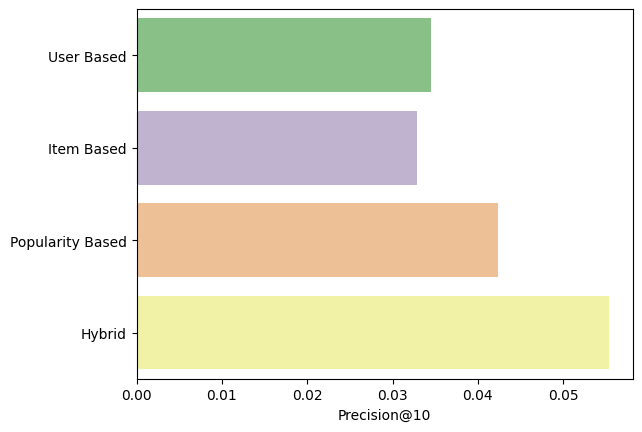

In [27]:
p = sb.barplot(x = list(precison_tmp.values()),y = list(precison_tmp.keys()), palette = "Accent")
p.set(xlabel = "Precision@10")

## Save model

In [101]:
save_sar(model_sar, r"C:\Users\tanch\Desktop\Bot.World\Bot.World\src\main\api\models", "arietes-sar")

In [116]:
9//2

4

## load and predict

In [35]:
save_path_str = r"C:\Users\tanch\Documents\NTU\NTU Year 4\FYP - GNN\Recommender API\deploy-fastapi-recommendation-system\src\api\models\epoch_50"
model.load(save_path_str)
top_k = model.recommend_k_items(test, top_k=TOP_K, remove_seen=True)
eval_precision = precision_at_k(test, top_k, col_user=USER_ID_COL, col_item=ITEM_ID_COL, col_rating=RATING_COL, k=TOP_K)
eval_precision     

INFO:tensorflow:Restoring parameters from C:\Users\tanch\Documents\NTU\NTU Year 4\FYP - GNN\Recommender API\deploy-fastapi-recommendation-system\src\api\models\epoch_50


0.005344585091420536

In [77]:
model.recommend_k_items(pd.DataFrame({"user_id":["1cp2upf59l"]}), top_k=TOP_K, remove_seen=True)

,user_id,item_id,prediction
0,1cp2upf59l,11845518959,1.731541
1,1cp2upf59l,18516275838,1.599467
2,1cp2upf59l,14303478270,1.242138
3,1cp2upf59l,14782140731,1.221002
4,1cp2upf59l,19564733962,1.061905
5,1cp2upf59l,15403421090,0.960976
6,1cp2upf59l,19906893746,0.942554
7,1cp2upf59l,14675758106,0.936188
8,1cp2upf59l,21433429878,0.828105
9,1cp2upf59l,13117027913,0.794699


In [1]:
import pandas as pd
data = pd.read_pickle(r"C:\Users\tanch\Documents\NTU\NTU Year 4\FYP - GNN\data\shopee-20221117T041452Z-001\interaction data\train.pkl")

In [8]:
data[data.user_id == "weirdyellow"   ].item_id

1508    17971710101
1513    22203168551
1506    16071702603
1512    21869596899
1504    14266408742
1510    20860078856
Name: item_id, dtype: int64

In [4]:
data.user_id.value_counts()[:10]

weirdyellow    6
alexsanzo      4
54bakery       4
bignphat       4
buycwy         3
lynasally      3
ms.idaa89      3
jelzheng       2
ismailtaib     2
johnwong435    2
Name: user_id, dtype: int64

In [11]:
media_data[media_data.product_id.isin(data[data.user_id == "weirdyellow"   ].item_id)]

,product_id,product_name,categories,image_url
33,22203168551,"Shoulder Ice Pack for Rotator Cuff Injuries, R...","100712 - Home & Living/Hand Warmers, Hot Water...",https://cf.shopee.sg/file/sg-11134201-22100-n8...
46,21869596899,Hip Ice Pack Wrap for Bursitis Pain Relief Reu...,"100712 - Home & Living/Hand Warmers, Hot Water...",https://cf.shopee.sg/file/sg-11134201-22120-x9...
84,20860078856,Wrist Ice Gel Pack with Support Brace for Hot ...,100432 - Health/Medical Supplies/Injury & Disa...,https://cf.shopee.sg/file/sg-11134201-22110-f2...
158,17971710101,SG Seller Ankle Pain Relieve hot cool gel pack...,100432 - Health/Medical Supplies/Injury & Disa...,https://cf.shopee.sg/file/2940d22807b793d0fec9...
210,16071702603,SG Seller Gel Ice pack Hot Cold Gel Bead Ice F...,100898 - Beauty/Skincare/Face Mask & Packs,https://cf.shopee.sg/file/22fd5268fa3093fd17ac...
242,14266408742,SG Seller Hot Cold Reusable and Flexible Gel I...,100432 - Health/Medical Supplies/Injury & Disa...,https://cf.shopee.sg/file/ae1eaf10e8858389c737...


In [13]:
global_model = SAR(
        col_user=USER_ID_COL,
        col_item=ITEM_ID_COL,
        col_rating=RATING_COL,
        similarity_type="jaccard", 
        time_decay_coefficient=30, 
        timedecay_formula=False,
        normalize=False
    )
sar_load(global_model, MODEL_DIR)

In [20]:
recommended_item_ids = []
by = "item"

if by == "user":
    model_output = global_model.recommend_k_items(test = pd.DataFrame({"user_id":["buycwy"]}), 
                                                  top_k=5, 
                                                  remove_seen=True)
elif by == "item":
    model_output = global_model.get_item_based_topk(items = pd.DataFrame({"item_id":[17069323572]}), 
                                                    top_k=5)
else:
    # recommend by popularity by default
    model_output = global_model.get_popularity_based_topk(top_k=5)


recommended_item_ids = model_output["item_id"].tolist()


AttributeError: 'NoneType' object has no attribute 'get'

In [19]:
model_output

,user_id,item_id,prediction
0,buycwy,17069323572,0.250000
1,buycwy,2952217870,0.125000
2,buycwy,3333330067,0.083333
3,buycwy,11845518959,0.083333
4,buycwy,18516275838,0.076923


In [16]:
recommended_item_ids

['buycwy', 'buycwy', 'buycwy', 'buycwy', 'buycwy']